## Теоретическая часть

1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?  
В чем принципиальные отличия item-item рекомендаций от ALS?


**Ответ:** Они похожи тем, что считаются по матрице интеракций user-item и основаны на поиске расстояний между соответственно юзерами или товарами. Разница в том, что они предсказывают. User-user предсказывает как похожие юзеры взаимодействуют с товаром. Item-item предсказывает похожие товары исходя из их взаимодействия с юзерами.

Матрица интеракций используется одна и та же в обоих случаях.

Item-item рекомендации от ALS отличаются тем, что в случае item-item мы находим расстояние между товарами, а в случае ALS - непосредственно предсказываем перемножая эмбеддинги.

2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров 

**Ответ:**
* факт добавления в избранное пользователем
* рейтинг товара, поставленный пользователем
* написание пользователем положительного/отрицательного отзыва о товаре

3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)

**Ответ:** ALS основана на линейной зависимости. В качестве информации в матрице интеракции используются коэффициенты или факт интеракции, но нельзя использовать, например, текст.

4. Мы рассматривали bm_25_weight. 
Опишите, как он работает. Как сделать рекомендации только на основе bm_25? (Можно и нужно пользоваться любыми источниками, приложите на них ссылки). Какие еще способы перевзвешивания user-item матрицы Вы знаете / можете предложить (ещё 2-3 способа)?
**Ответ:** принципиально он похож на TF-IDF. Т.е. он поощряет за частоту слова в документе (TF) и штрафует, если это слово "не уникальное" и часто используется в других документах (IDF). 

Отличается тем, что содержит доп. гиперпараметры, особенно в части отвечающей за TF. Преимущество перед обычным TF-IDF в том, что BM_25 учитывает длинну документа (коэффициент $b$) и позволяет подбирать как сильно влияет повтор слов на общий score (коэффициент $k1$).

Чтобы сделать рекомендации только на основе BM_25 можно взвесить векторы user'ов или item'ов, а потом использовать метод поиска ближайших соседей, как мы делали когда изучали user-user и item-item recommender.

User-item матрицу можно перевзвешивать также с помощью TF-IDF или с помощью косинусного расстояния.

## Практическая часть


In [2]:
!pip install implicit

     |████████████████████████████████| 1.1MB 18.4MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp37-cp37m-linux_x86_64.whl size=3404901 sha256=94801c6b09771857c3280a943baaf174e2cde64a2e6ffec5941a350c55395409
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 14})

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    #print(flags)
    
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [6]:
data = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/recommender_systems/data/retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [7]:
item_features = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/recommender_systems/data/product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [8]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']

result_train = data_train.groupby('user_id')['item_id'].unique().reset_index()
result_train.columns=['user_id', 'actual_train']

result = pd.merge(result, result_train, on="user_id")
result.head(2)

,user_id,actual,actual_train
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[825123, 831447, 840361, 845307, 852014, 85498..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[866211, 878996, 882830, 904360, 921345, 93194..."


In [9]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.


In [10]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [11]:
# user-item матрица, где  в качестве интеракции - колличество покупок. Но тут могла бы быть и стоимость, рейтинг выставленный пользователем или добавление в избранное.
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='sales_value', # Можно пробовать другие варианты
                                  aggfunc='sum', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

In [12]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

csr_mat = csr_matrix(user_item_matrix).T.tocsr()

In [13]:
%%time

model = AlternatingLeastSquares(factors=100, # k - кол-во эмбеддингов, т.е. латентных факторов для матриц разложения
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True,
                                use_gpu=True,  # Изначально не было, но добавил False, чтобы разрешить ошибку "Cuda Error: no CUDA-capable device is detected"
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

GPU training requires factor size to be a multiple of 32. Increasing factors from 100 to 128.



CPU times: user 778 ms, sys: 416 ms, total: 1.19 s
Wall time: 2.49 s


In [14]:
%%time
    
result['als_sales_value'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['als_sales_value'], row['actual']), axis=1).mean()

CPU times: user 40.8 s, sys: 31.6 s, total: 1min 12s
Wall time: 36.7 s


In [15]:
als_sales_value_score = result.apply(lambda row: precision_at_k(row['als_sales_value'], row['actual']), axis=1).mean()
als_sales_value_score_train = result.apply(lambda row: precision_at_k(row['als_sales_value'], row['actual_train']), axis=1).mean()
print(f'P@5 on train: {als_sales_value_score_train}')
print(f'P@5 on test: {als_sales_value_score}')

P@5 on train: 0.6870714985308419
P@5 on test: 0.10548481880509242


In [16]:
# user-item матрица, где  в качестве интеракции - колличество покупок. Но тут могла бы быть и стоимость, рейтинг выставленный пользователем или добавление в избранное.
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='sales_value', # Можно пробовать другие варианты
                                  aggfunc='mean', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

In [17]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

csr_mat = csr_matrix(user_item_matrix).T.tocsr()

In [18]:
%%time

model = AlternatingLeastSquares(factors=100, # k - кол-во эмбеддингов, т.е. латентных факторов для матриц разложения
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True,
                                use_gpu=True,  # Изначально не было, но добавил False, чтобы разрешить ошибку "Cuda Error: no CUDA-capable device is detected"
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)


CPU times: user 620 ms, sys: 276 ms, total: 897 ms
Wall time: 939 ms


In [19]:
%%time
    
result['als_sales_value_mean'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['als_sales_value_mean'], row['actual']), axis=1).mean()

CPU times: user 40.9 s, sys: 31.5 s, total: 1min 12s
Wall time: 36.6 s


In [20]:
als_sales_value_mean_score = result.apply(lambda row: precision_at_k(row['als_sales_value_mean'], row['actual']), axis=1).mean()
als_sales_value_mean_score_train = result.apply(lambda row: precision_at_k(row['als_sales_value_mean'], row['actual_train']), axis=1).mean()
print(f'P@5 on train: {als_sales_value_mean_score_train}')
print(f'P@5 on test: {als_sales_value_mean_score}')

P@5 on train: 0.797747306562176
P@5 on test: 0.1353574926542592


In [21]:
# user-item матрица, где  в качестве интеракции - колличество покупок. Но тут могла бы быть и стоимость, рейтинг выставленный пользователем или добавление в избранное.
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='sales_value', # Можно пробовать другие варианты
                                  aggfunc='max', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

In [22]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

csr_mat = csr_matrix(user_item_matrix).T.tocsr()

In [23]:
%%time

model = AlternatingLeastSquares(factors=100, # k - кол-во эмбеддингов, т.е. латентных факторов для матриц разложения
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True,
                                use_gpu=True,  # Изначально не было, но добавил False, чтобы разрешить ошибку "Cuda Error: no CUDA-capable device is detected"
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)


CPU times: user 594 ms, sys: 268 ms, total: 862 ms
Wall time: 908 ms


In [24]:
%%time
    
result['als_sales_value_max'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['als_sales_value_max'], row['actual']), axis=1).mean()

CPU times: user 40.7 s, sys: 31.5 s, total: 1min 12s
Wall time: 36.5 s


In [25]:
als_sales_value_max_score = result.apply(lambda row: precision_at_k(row['als_sales_value_max'], row['actual']), axis=1).mean()
als_sales_value_max_score_train = result.apply(lambda row: precision_at_k(row['als_sales_value_max'], row['actual_train']), axis=1).mean()
print(f'P@5 on train: {als_sales_value_max_score_train}')
print(f'P@5 on test: {als_sales_value_max_score}')

P@5 on train: 0.788246816846212
P@5 on test: 0.12928501469147774


In [26]:
# user-item матрица, где  в качестве интеракции - колличество покупок. Но тут могла бы быть и стоимость, рейтинг выставленный пользователем или добавление в избранное.
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

In [27]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

csr_mat = csr_matrix(user_item_matrix).T.tocsr()

In [28]:
%%time

model = AlternatingLeastSquares(factors=100, # k - кол-во эмбеддингов, т.е. латентных факторов для матриц разложения
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True,
                                use_gpu=True,  # Изначально не было, но добавил False, чтобы разрешить ошибку "Cuda Error: no CUDA-capable device is detected"
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)


CPU times: user 600 ms, sys: 286 ms, total: 886 ms
Wall time: 908 ms


In [29]:
%%time
    
result['als_quantity'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['als_quantity'], row['actual']), axis=1).mean()

CPU times: user 40.7 s, sys: 31.8 s, total: 1min 12s
Wall time: 36.7 s


In [30]:
als_quantity_score = result.apply(lambda row: precision_at_k(row['als_quantity'], row['actual']), axis=1).mean()
als_quantity_score_train = result.apply(lambda row: precision_at_k(row['als_quantity'], row['actual_train']), axis=1).mean()
print(f'P@5 on train: {als_quantity_score_train}')
print(f'P@5 on test: {als_quantity_score}')

P@5 on train: 0.8108716944172242
P@5 on test: 0.15543584720861717


In [31]:
pd.DataFrame(np.array([[als_sales_value_score_train, als_sales_value_score], 
                       [als_sales_value_mean_score_train, als_sales_value_mean_score], 
                       [als_sales_value_max_score_train, als_sales_value_max_score], 
                       [als_quantity_score_train, als_quantity_score]]), index=['C = sales value sum', 'C = sales value mean', 'C = sales value max', 'C = quantity'], columns=['Train', 'Test'])

,Train,Test
C = sales value sum,0.687071,0.105485
C = sales value mean,0.797747,0.135357
C = sales value max,0.788247,0.129285
C = quantity,0.810872,0.155436


**Вывод:** лучший результат показала таблица интеракций по колличеству покупок. Кажется это логично, ведь мы сравниваем по метрике precision@k, которая больше про факт взаимодействие, чем про стоимость покупок. Если бы мы измеряли эффективность по money_precision@k, то может быть получился другой результат.

### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.RandomSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы.

Варианты гиперпараметров:
* num_factors: The number of latent factors, or degree of dimensionality in our model
* regularization: Scale of regularization for both user and item factors
* alpha: Our confidence scaling term ($c_{ui} = 1 + \alpha \cdot d_{ui}$)
* iterations: Number of iterations to run Alternating Least Squares optimization

(src - https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/)

In [32]:
%%time

factors_list = [32, 64, 128] 
regularization_list = [0.001, 0.005, 0.01]
iterations_list = [8, 10, 20]
grid = []

for factors in factors_list:
    for regularization in regularization_list:
        for iterations in iterations_list:
            grid_row = []
            grid_row.append(factors)
            grid_row.append(regularization)
            grid_row.append(iterations)

            model = AlternatingLeastSquares(factors=factors, # k - кол-во эмбеддингов, т.е. латентных факторов для матриц разложения
                                regularization=regularization,
                                iterations=iterations, 
                                calculate_training_loss=True,
                                use_gpu=True, # Изначально не было, но добавил False, чтобы разрешить ошибку "Cuda Error: no CUDA-capable device is detected"
                                num_threads=8)

            model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
                      show_progress=True)
            result[f'als_f{factors}_r{regularization}_i{iterations}'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
            grid_row.append(result.apply(lambda row: precision_at_k(row[f'als_f{factors}_r{regularization}_i{iterations}'], row['actual']), axis=1).mean())
            grid_row.append(result.apply(lambda row: precision_at_k(row[f'als_f{factors}_r{regularization}_i{iterations}'], row['actual_train']), axis=1).mean())
            grid.append(grid_row)


CPU times: user 12min 10s, sys: 9min 18s, total: 21min 29s
Wall time: 11min 4s


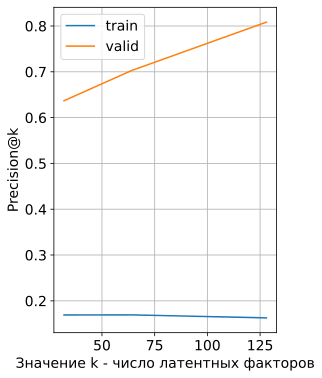

In [55]:
plt.rcParams['figure.figsize'] = 4, 6

pk_train = []
pk_valid = []
for factor in factors_list:
    find_max_train = []
    find_max_valid = []
    for row in grid:
        if row[0]==factor:
            find_max_train.append(row[3])
            find_max_valid.append(row[4])
    pk_train.append(max(find_max_train))
    pk_valid.append(max(find_max_valid))

plt.plot(factors_list, pk_train, label="train")
plt.plot(factors_list, pk_valid, label="valid")

plt.xlabel('Значение k - число латентных факторов')
plt.ylabel('Precision@k')

plt.legend()
plt.grid()

plt.show()

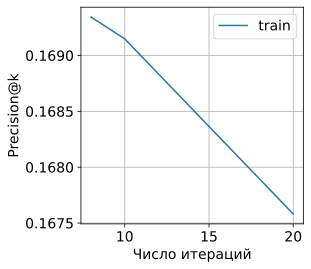

In [65]:
plt.rcParams['figure.figsize'] = 4, 4

pk_train = []
pk_valid = []
for iterations in iterations_list:
    find_max_train = []
    find_max_valid = []
    for row in grid:
        if row[2]==iterations:
            find_max_train.append(row[3])
            find_max_valid.append(row[4])
    pk_train.append(max(find_max_train))
    pk_valid.append(max(find_max_valid))

plt.plot(iterations_list, pk_train, label="train")
#plt.plot(iterations_list, pk_valid, label="valid")

plt.xlabel('Число итераций')
plt.ylabel('Precision@k')

plt.legend()
plt.grid()

plt.show()

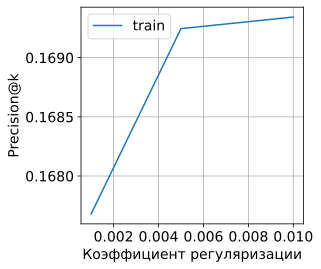

In [70]:
plt.rcParams['figure.figsize'] = 4, 4

pk_train = []
pk_valid = []
for regularization in regularization_list:
    find_max_train = []
    find_max_valid = []
    for row in grid:
        if row[1]==regularization:
            find_max_train.append(row[3])
            find_max_valid.append(row[4])
    pk_train.append(max(find_max_train))
    pk_valid.append(max(find_max_valid))

plt.plot(regularization_list, pk_train, label="train")
#plt.plot(regularization_list, pk_valid, label="valid")

plt.xlabel('Коэффициент регуляризации')
plt.ylabel('Precision@k')

plt.legend()
plt.grid()

plt.show()

In [34]:
for row in sorted(grid, key=lambda x: x[3], reverse=True):
    print(f'Factors: {row[0]}, reg: {row[1]}, iter: {row[2]}, test: {row[3]}, train: {row[4]}')

Factors: 64, reg: 0.01, iter: 8, test: 0.1693437806072456, train: 0.6941234084231058
Factors: 64, reg: 0.005, iter: 8, test: 0.16924583741429733, train: 0.6907933398628713
Factors: 64, reg: 0.005, iter: 10, test: 0.16914789422134952, train: 0.6998041136140952
Factors: 32, reg: 0.005, iter: 8, test: 0.16914789422134893, train: 0.6280117531831488
Factors: 64, reg: 0.01, iter: 10, test: 0.169049951028401, train: 0.694809010773742
Factors: 64, reg: 0.001, iter: 8, test: 0.16767874632712804, train: 0.6976493633692367
Factors: 32, reg: 0.01, iter: 8, test: 0.1675808031341798, train: 0.6169441723800145
Factors: 32, reg: 0.001, iter: 20, test: 0.16758080313417978, train: 0.6368266405484765
Factors: 32, reg: 0.001, iter: 10, test: 0.16699314397649132, train: 0.6314397649363314
Factors: 32, reg: 0.01, iter: 20, test: 0.16699314397649132, train: 0.6265426052889281
Factors: 32, reg: 0.01, iter: 10, test: 0.16660137120469903, train: 0.6252693437806014
Factors: 64, reg: 0.001, iter: 10, test: 0.1662

**Вывод:** Оптимальное значение precision@k = 0.1693 я добился при значениях k=64, регуляризации 0.01 и числе итераций 8. Подбор параметров позволил на 7% улучшить модель. Меня удивило, что лучшее качество получалось при меньшем числе итераций. Это кажется странно, ведь вроде бы чем больше итераций, тем лучше данные должны были бы сходиться.

Мне кажется, в данном случае бОльшее число итераций приводило к "переобучению" модели - это и ухудшало качество на тесте.

Чем больше значение k, тем меньше был loss, но кажется это должно было привести к тому, что при k=128 мы получим лучшие результаты, но это тоже оказалось не так. Наоборот, k=128 дало худшие результаты при относительно меньшем loss.